In [1]:
import cv2
import h5py
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
from itertools import combinations
from toolz import groupby, valmap, partial
from aging.plotting import legend

In [2]:
folder = Path('/n/groups/datta/eli/Height_Test')
files = sorted(folder.glob('**/results_00.h5'))

In [3]:
def get_name(file):
    try:
        with h5py.File(file, 'r') as h5f:
            return h5f['metadata/acquisition/SubjectName'][()].decode()
    except BlockingIOError:
        return None

In [4]:
file_grp = groupby(get_name, files)

In [5]:
file_grp

{'C1_N': [PosixPath('/n/groups/datta/eli/Height_Test/session_20230809145215/proc/results_00.h5'),
  PosixPath('/n/groups/datta/eli/Height_Test/session_20230810133030/proc/results_00.h5'),
  PosixPath('/n/groups/datta/eli/Height_Test/session_20230810155753/proc/results_00.h5'),
  PosixPath('/n/groups/datta/eli/Height_Test/session_20230811103024/proc/results_00.h5'),
  PosixPath('/n/groups/datta/eli/Height_Test/session_20230811171317/proc/results_00.h5')],
 'C1_L': [PosixPath('/n/groups/datta/eli/Height_Test/session_20230809151128/proc/results_00.h5'),
  PosixPath('/n/groups/datta/eli/Height_Test/session_20230810131315/proc/results_00.h5'),
  PosixPath('/n/groups/datta/eli/Height_Test/session_20230810153528/proc/results_00.h5'),
  PosixPath('/n/groups/datta/eli/Height_Test/session_20230811105153/proc/results_00.h5'),
  PosixPath('/n/groups/datta/eli/Height_Test/session_20230811165907/proc/results_00.h5')],
 'C1_R': [PosixPath('/n/groups/datta/eli/Height_Test/session_20230809152544/proc/r

In [6]:
mouse_files = file_grp['C1_RR']

In [7]:
def gather_mouse_data(files):
    out = {}
    height = {}
    out_filter = {}
    for f in tqdm(files):
        with h5py.File(f, "r") as h5f:
            td = h5f["metadata/extraction/true_depth"][()]
            height[td] = np.sum(h5f["frames"] * (h5f["frames"][()] > 10), axis=(1, 2)) / np.sum(
                h5f["frames"][()] > 10, axis=(1, 2)
            )
            out[td] = np.median(h5f["frames"], axis=0)
            out_filter[td] = np.median(h5f['frames'][height[td] < 31], axis=0)
    return out, height, out_filter

In [8]:
out, height, out_filter = gather_mouse_data(mouse_files)

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_5131/3481646326.py:8: RuntimeWarning: invalid value encountered in divide
  height[td] = np.sum(h5f["frames"] * (h5f["frames"][()] > 10), axis=(1, 2)) / np.sum(


In [9]:
valmap(np.nanmedian, height)

{595.0: 27.600502512562816,
 620.0: 28.208915594809756,
 645.0: 28.41422145163131,
 670.0: 27.321543408360128,
 700.0: 27.6104567933368}

In [10]:
len(out)

5

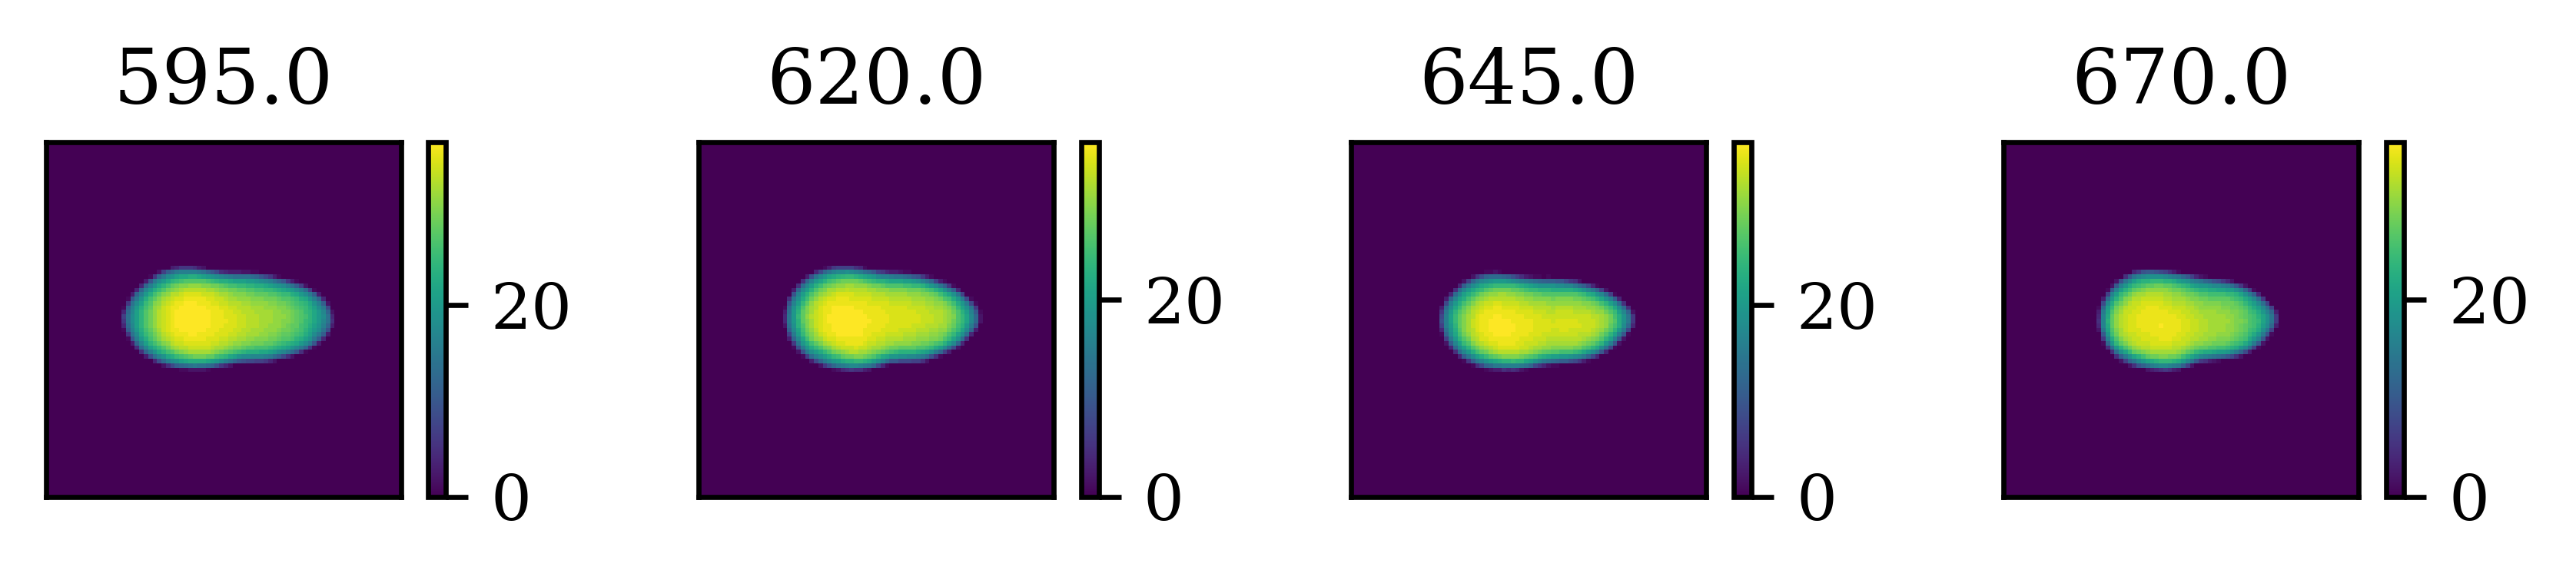

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(7, 1))
for (k, v), a in zip(out.items(), ax):
    im = a.imshow(v)
    a.set(title=k, xticks=[], yticks=[])
    fig.colorbar(im, ax=a)

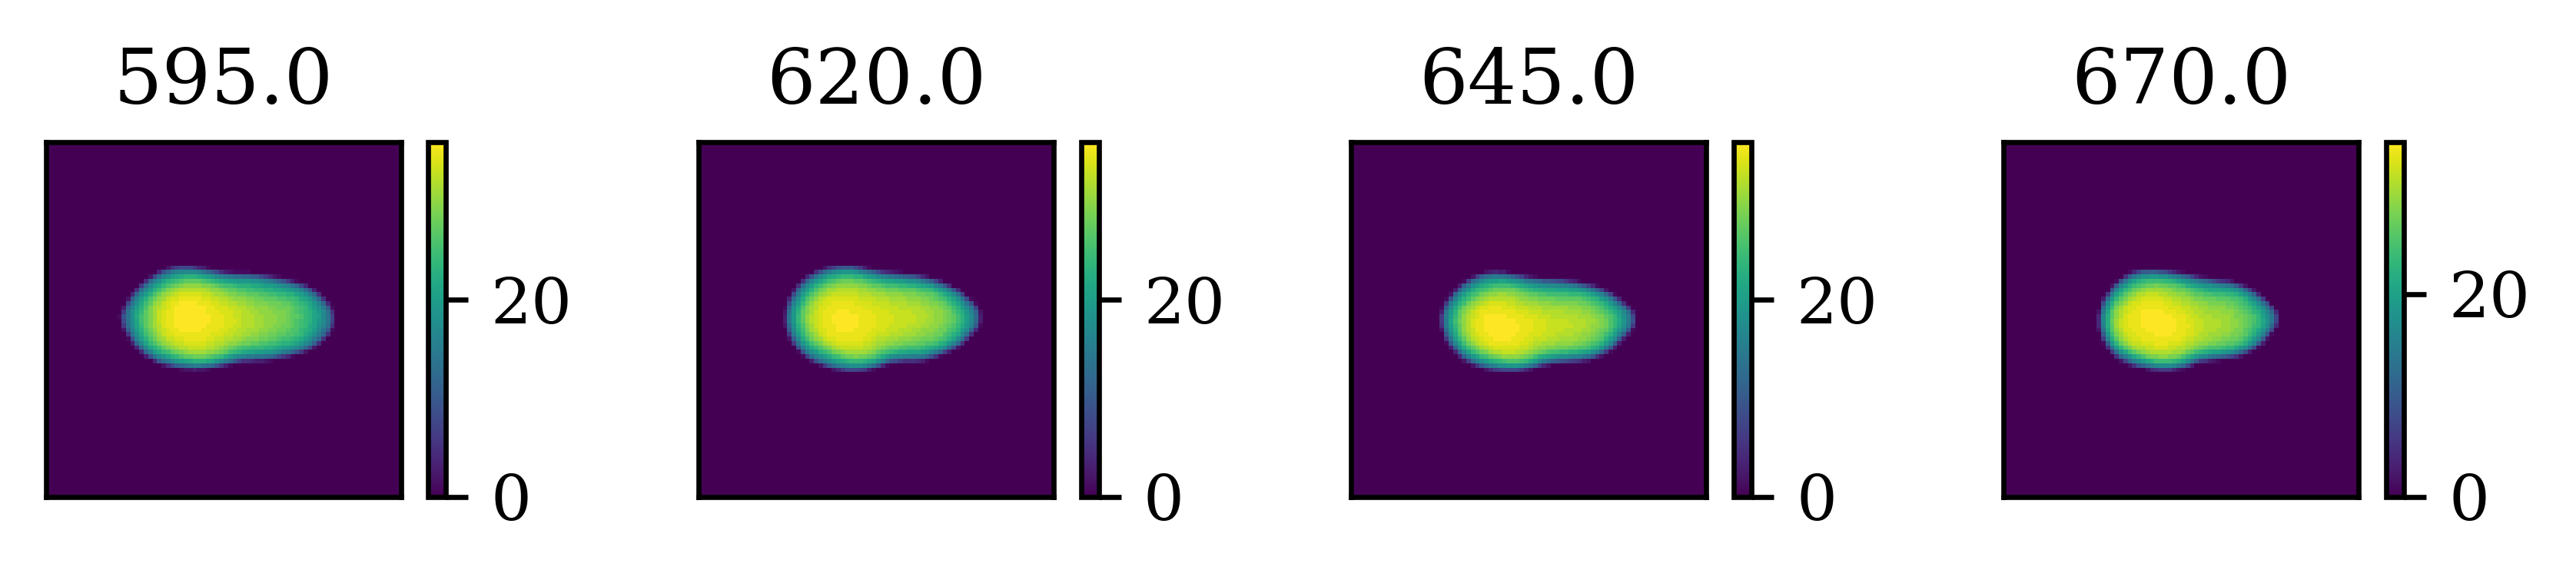

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(7, 1))
for (k, v), a in zip(out_filter.items(), ax):
    im = a.imshow(v)
    a.set(title=k, xticks=[], yticks=[])
    fig.colorbar(im, ax=a)

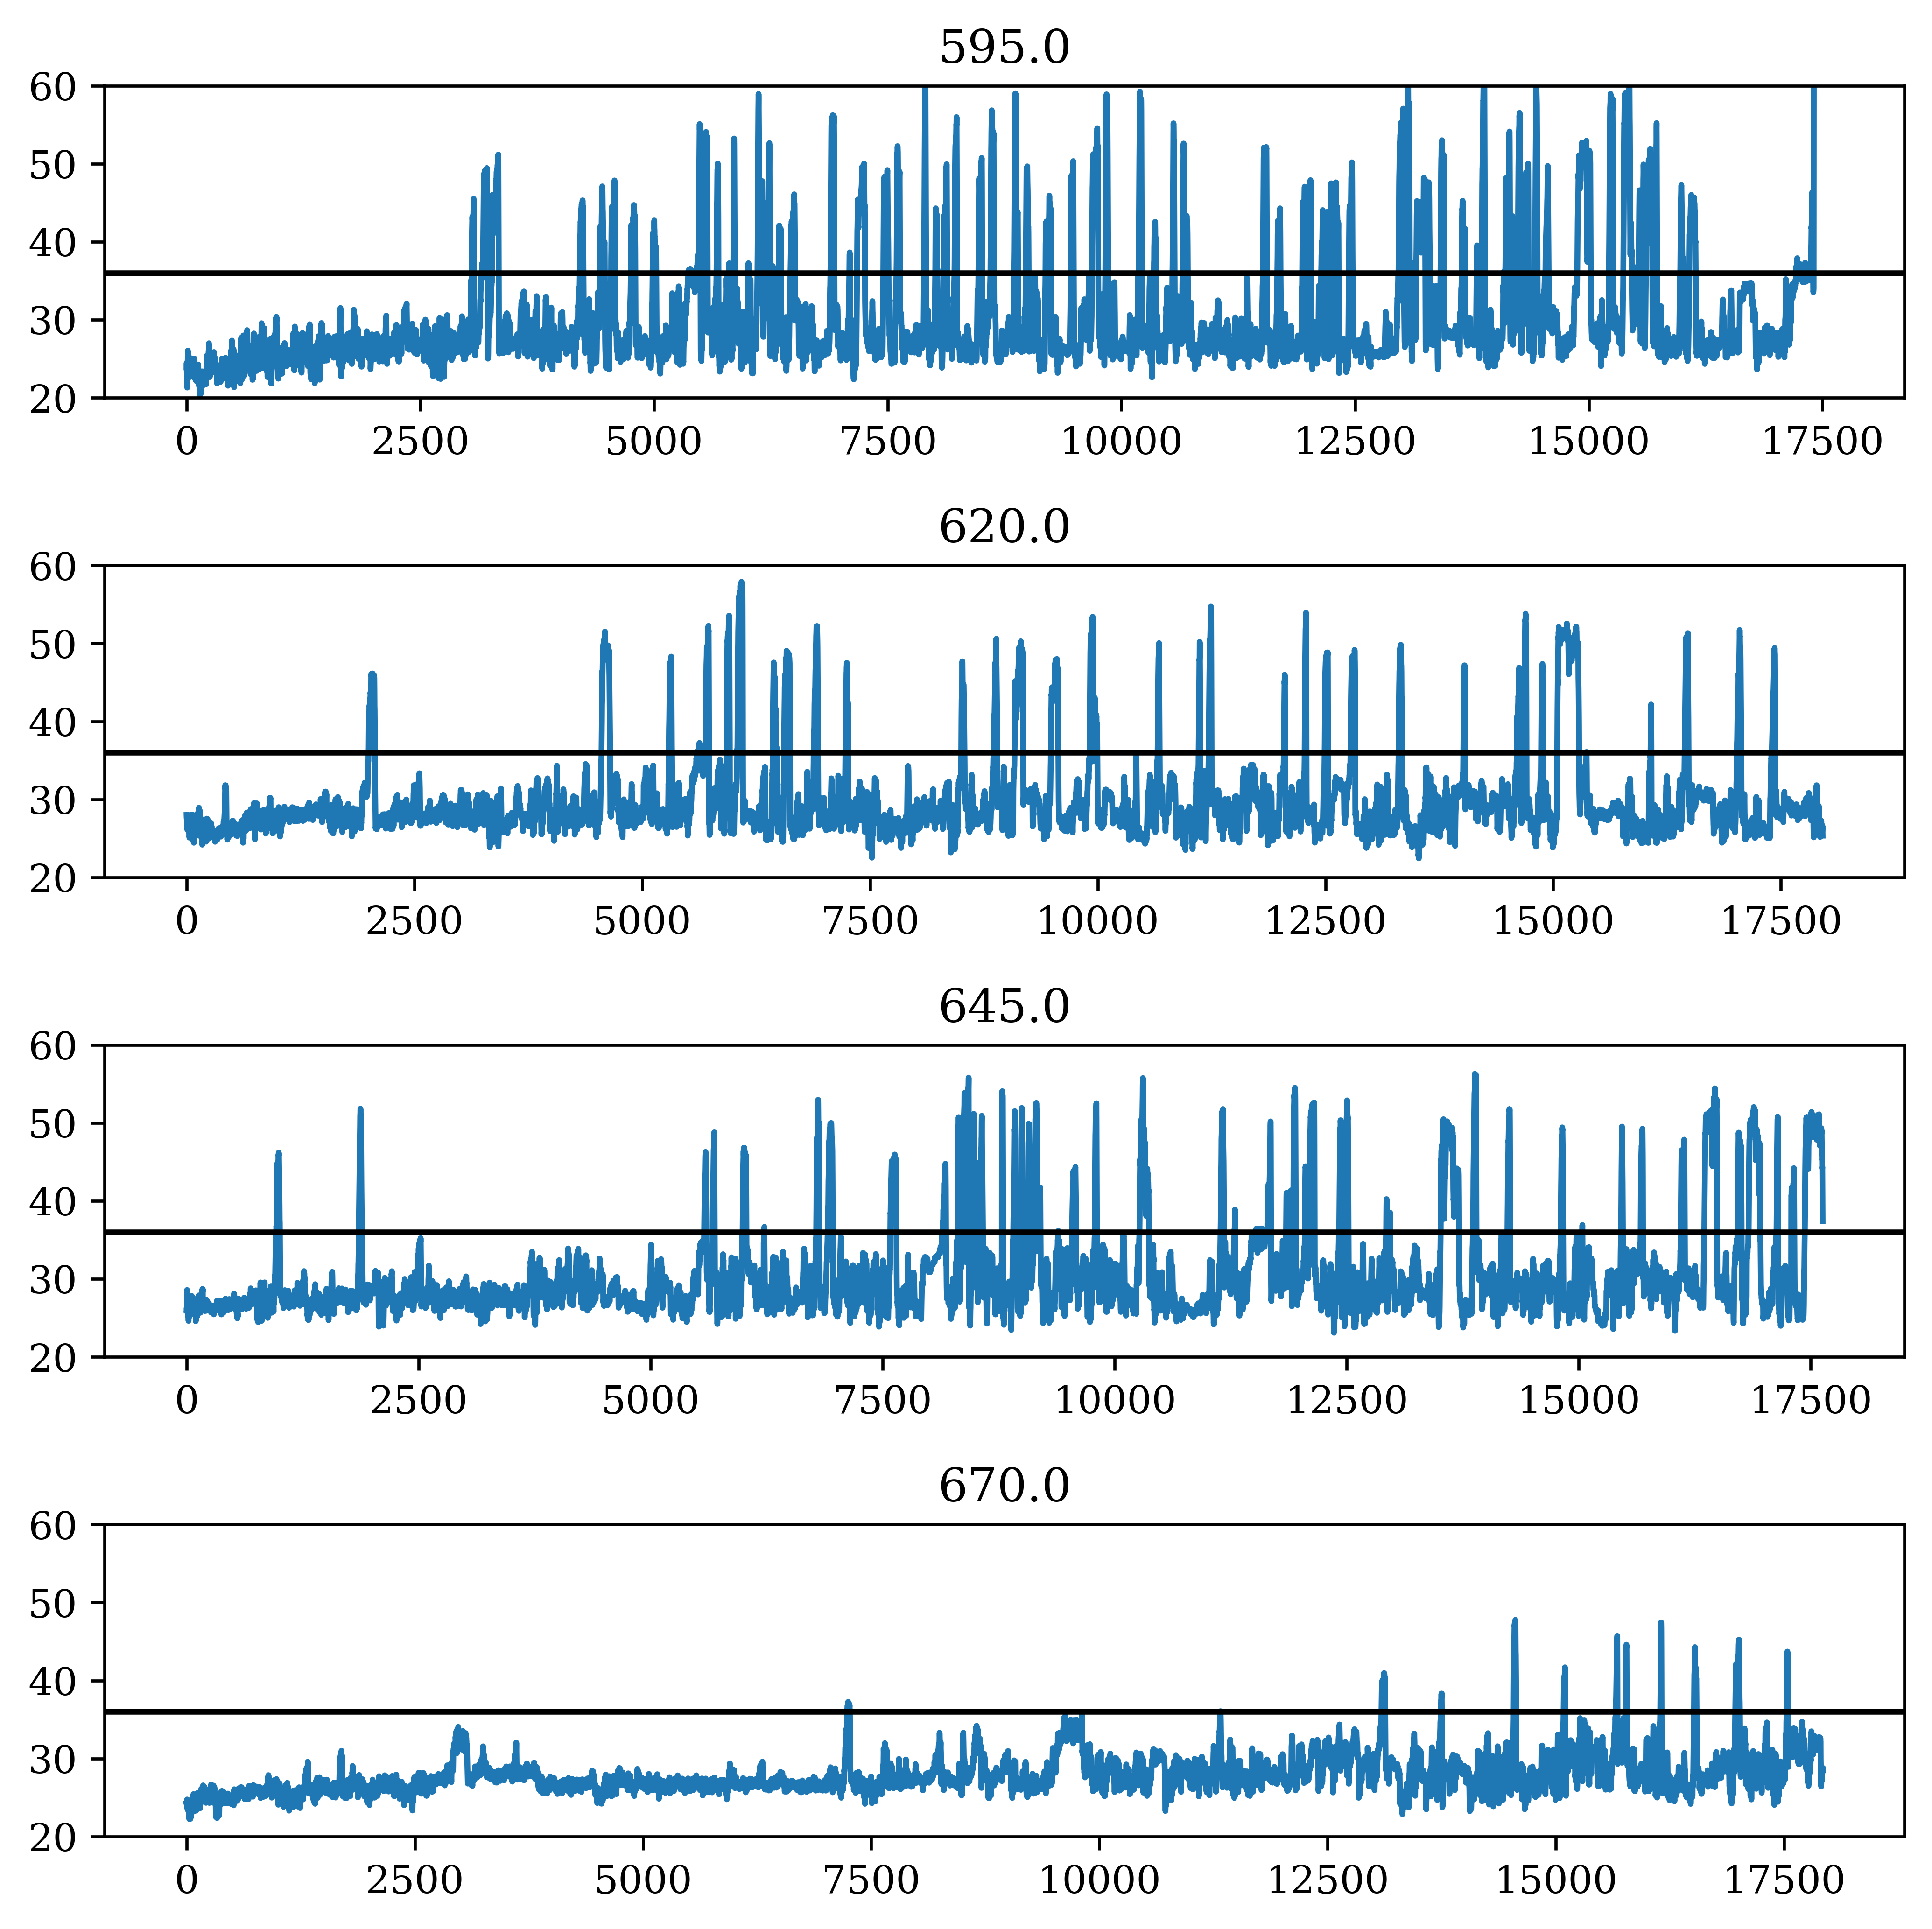

In [13]:
fig, ax = plt.subplots(4, 1, figsize=(7, 7))
for (k, v), a in zip(height.items(), ax):
    im = a.plot(v)
    a.axhline(36, color='k')
    a.set(title=k, ylim=(20, 60))
fig.tight_layout()

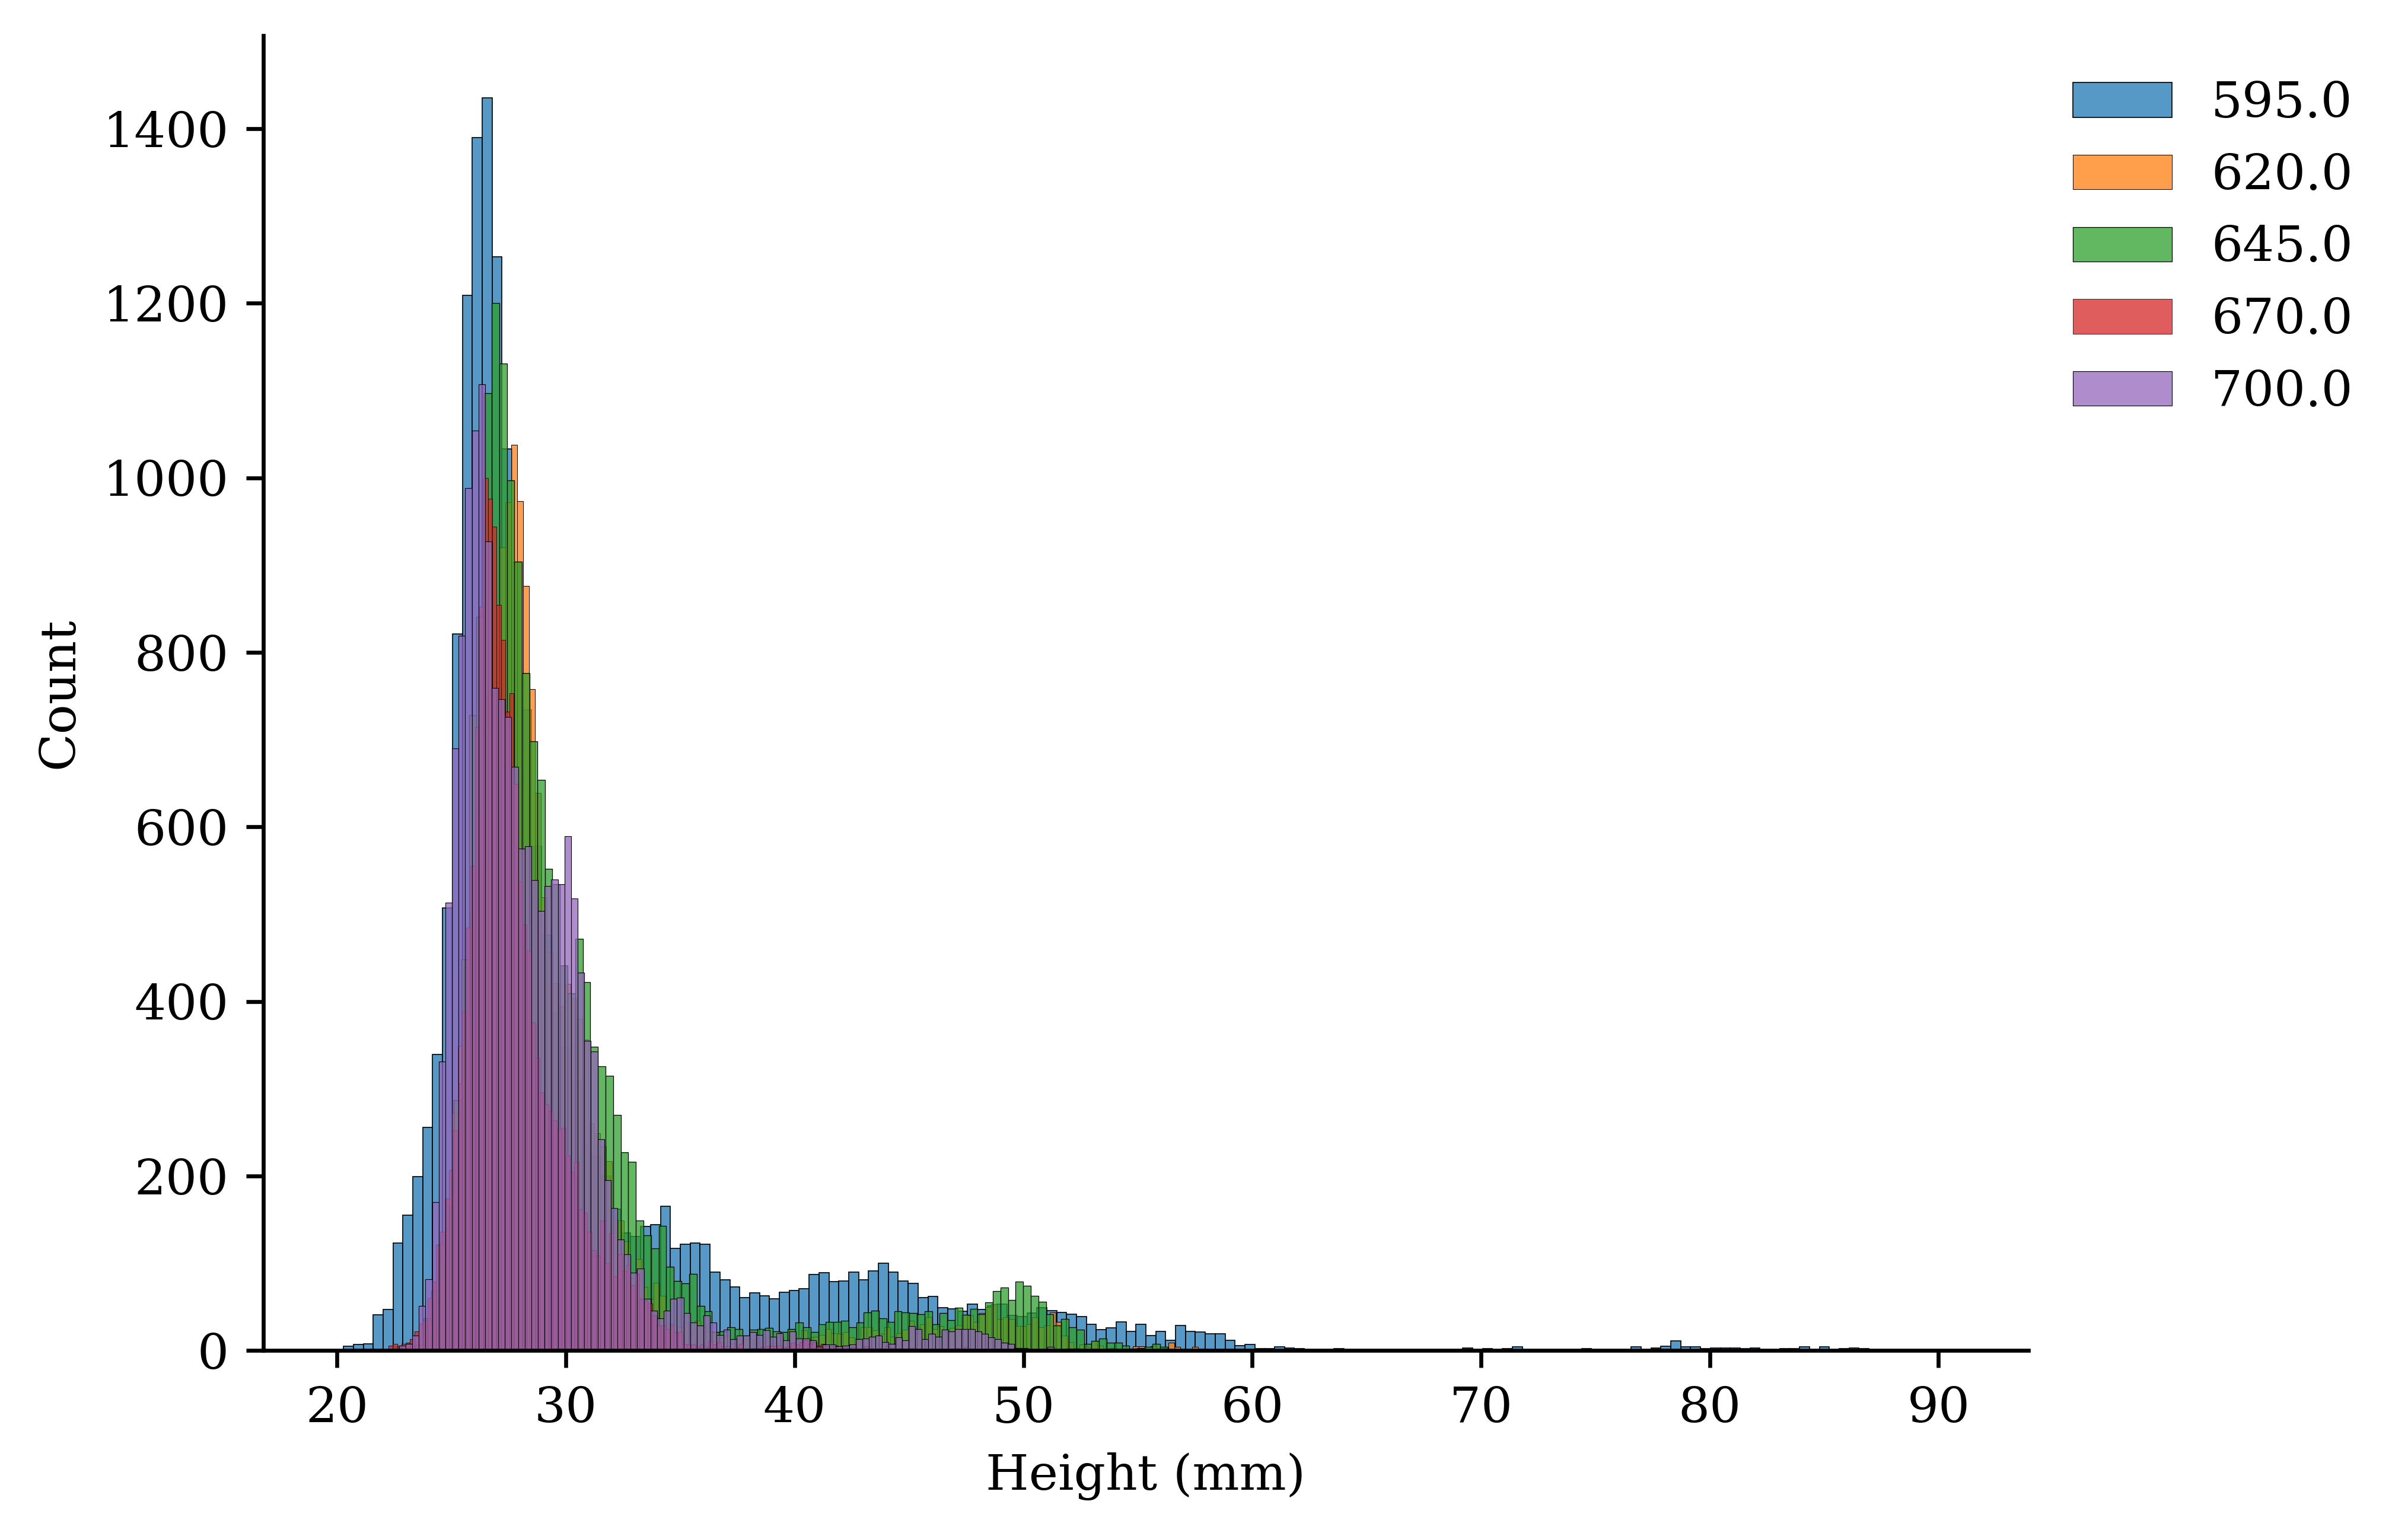

In [14]:
for k, v in height.items():
    a = sns.histplot(v, label=k)
a.set(xlabel='Height (mm)')
sns.despine()
legend()

In [15]:
# what scaling do I have to do to make i.e., 670, look like any of the other sizes?

def fun(scale, input_im, target_im):
    '''scale input to match target'''
    # print(scale)
    if isinstance(scale, np.ndarray):
        scale = scale[0]
    warp_mat = cv2.getRotationMatrix2D((input_im.shape[0] // 2, input_im.shape[1] // 2), 0, scale)
    out_im = cv2.warpAffine(input_im, warp_mat, input_im.shape, flags=cv2.INTER_LINEAR)
    return np.mean(np.square(target_im - out_im))

In [16]:
def compute_scalings(out_filter):
    scales = np.linspace(0.5, 1.5, 201)
    factors = {}
    mtx = np.zeros((len(out_filter), ) * 2) * np.nan
    for (i1, (k1, v1)), (i2, (k2, v2)) in combinations(enumerate(out_filter.items()), 2):
        f = partial(fun, input_im=v1, target_im=v2)
        mses = []
        for i in scales:
            mses.append(f(i))
        factors[(k1, k2)] = scales[np.argmin(mses)]
        mtx[i1, i2] = factors[(k1, k2)]
        f = partial(fun, input_im=v2, target_im=v1)
        mses = []
        for i in scales:
            mses.append(f(i))
        factors[(k2, k1)] = scales[np.argmin(mses)]
        mtx[i2, i1] = factors[(k2, k1)]

    for k, v in out_filter.items():
        factors[(k, k)] = 1
    return factors, mtx

In [17]:
factors, mtx = compute_scalings(out_filter)

In [18]:
factors

{(595.0, 620.0): 0.9650000000000001,
 (620.0, 595.0): 1.03,
 (595.0, 645.0): 0.9299999999999999,
 (645.0, 595.0): 1.07,
 (595.0, 670.0): 0.895,
 (670.0, 595.0): 1.105,
 (595.0, 700.0): 0.81,
 (700.0, 595.0): 1.2349999999999999,
 (620.0, 645.0): 0.9650000000000001,
 (645.0, 620.0): 1.0350000000000001,
 (620.0, 670.0): 0.9299999999999999,
 (670.0, 620.0): 1.0750000000000002,
 (620.0, 700.0): 0.8400000000000001,
 (700.0, 620.0): 1.185,
 (645.0, 670.0): 0.96,
 (670.0, 645.0): 1.03,
 (645.0, 700.0): 0.865,
 (700.0, 645.0): 1.15,
 (670.0, 700.0): 0.905,
 (700.0, 670.0): 1.1099999999999999,
 (595.0, 595.0): 1,
 (620.0, 620.0): 1,
 (645.0, 645.0): 1,
 (670.0, 670.0): 1,
 (700.0, 700.0): 1}

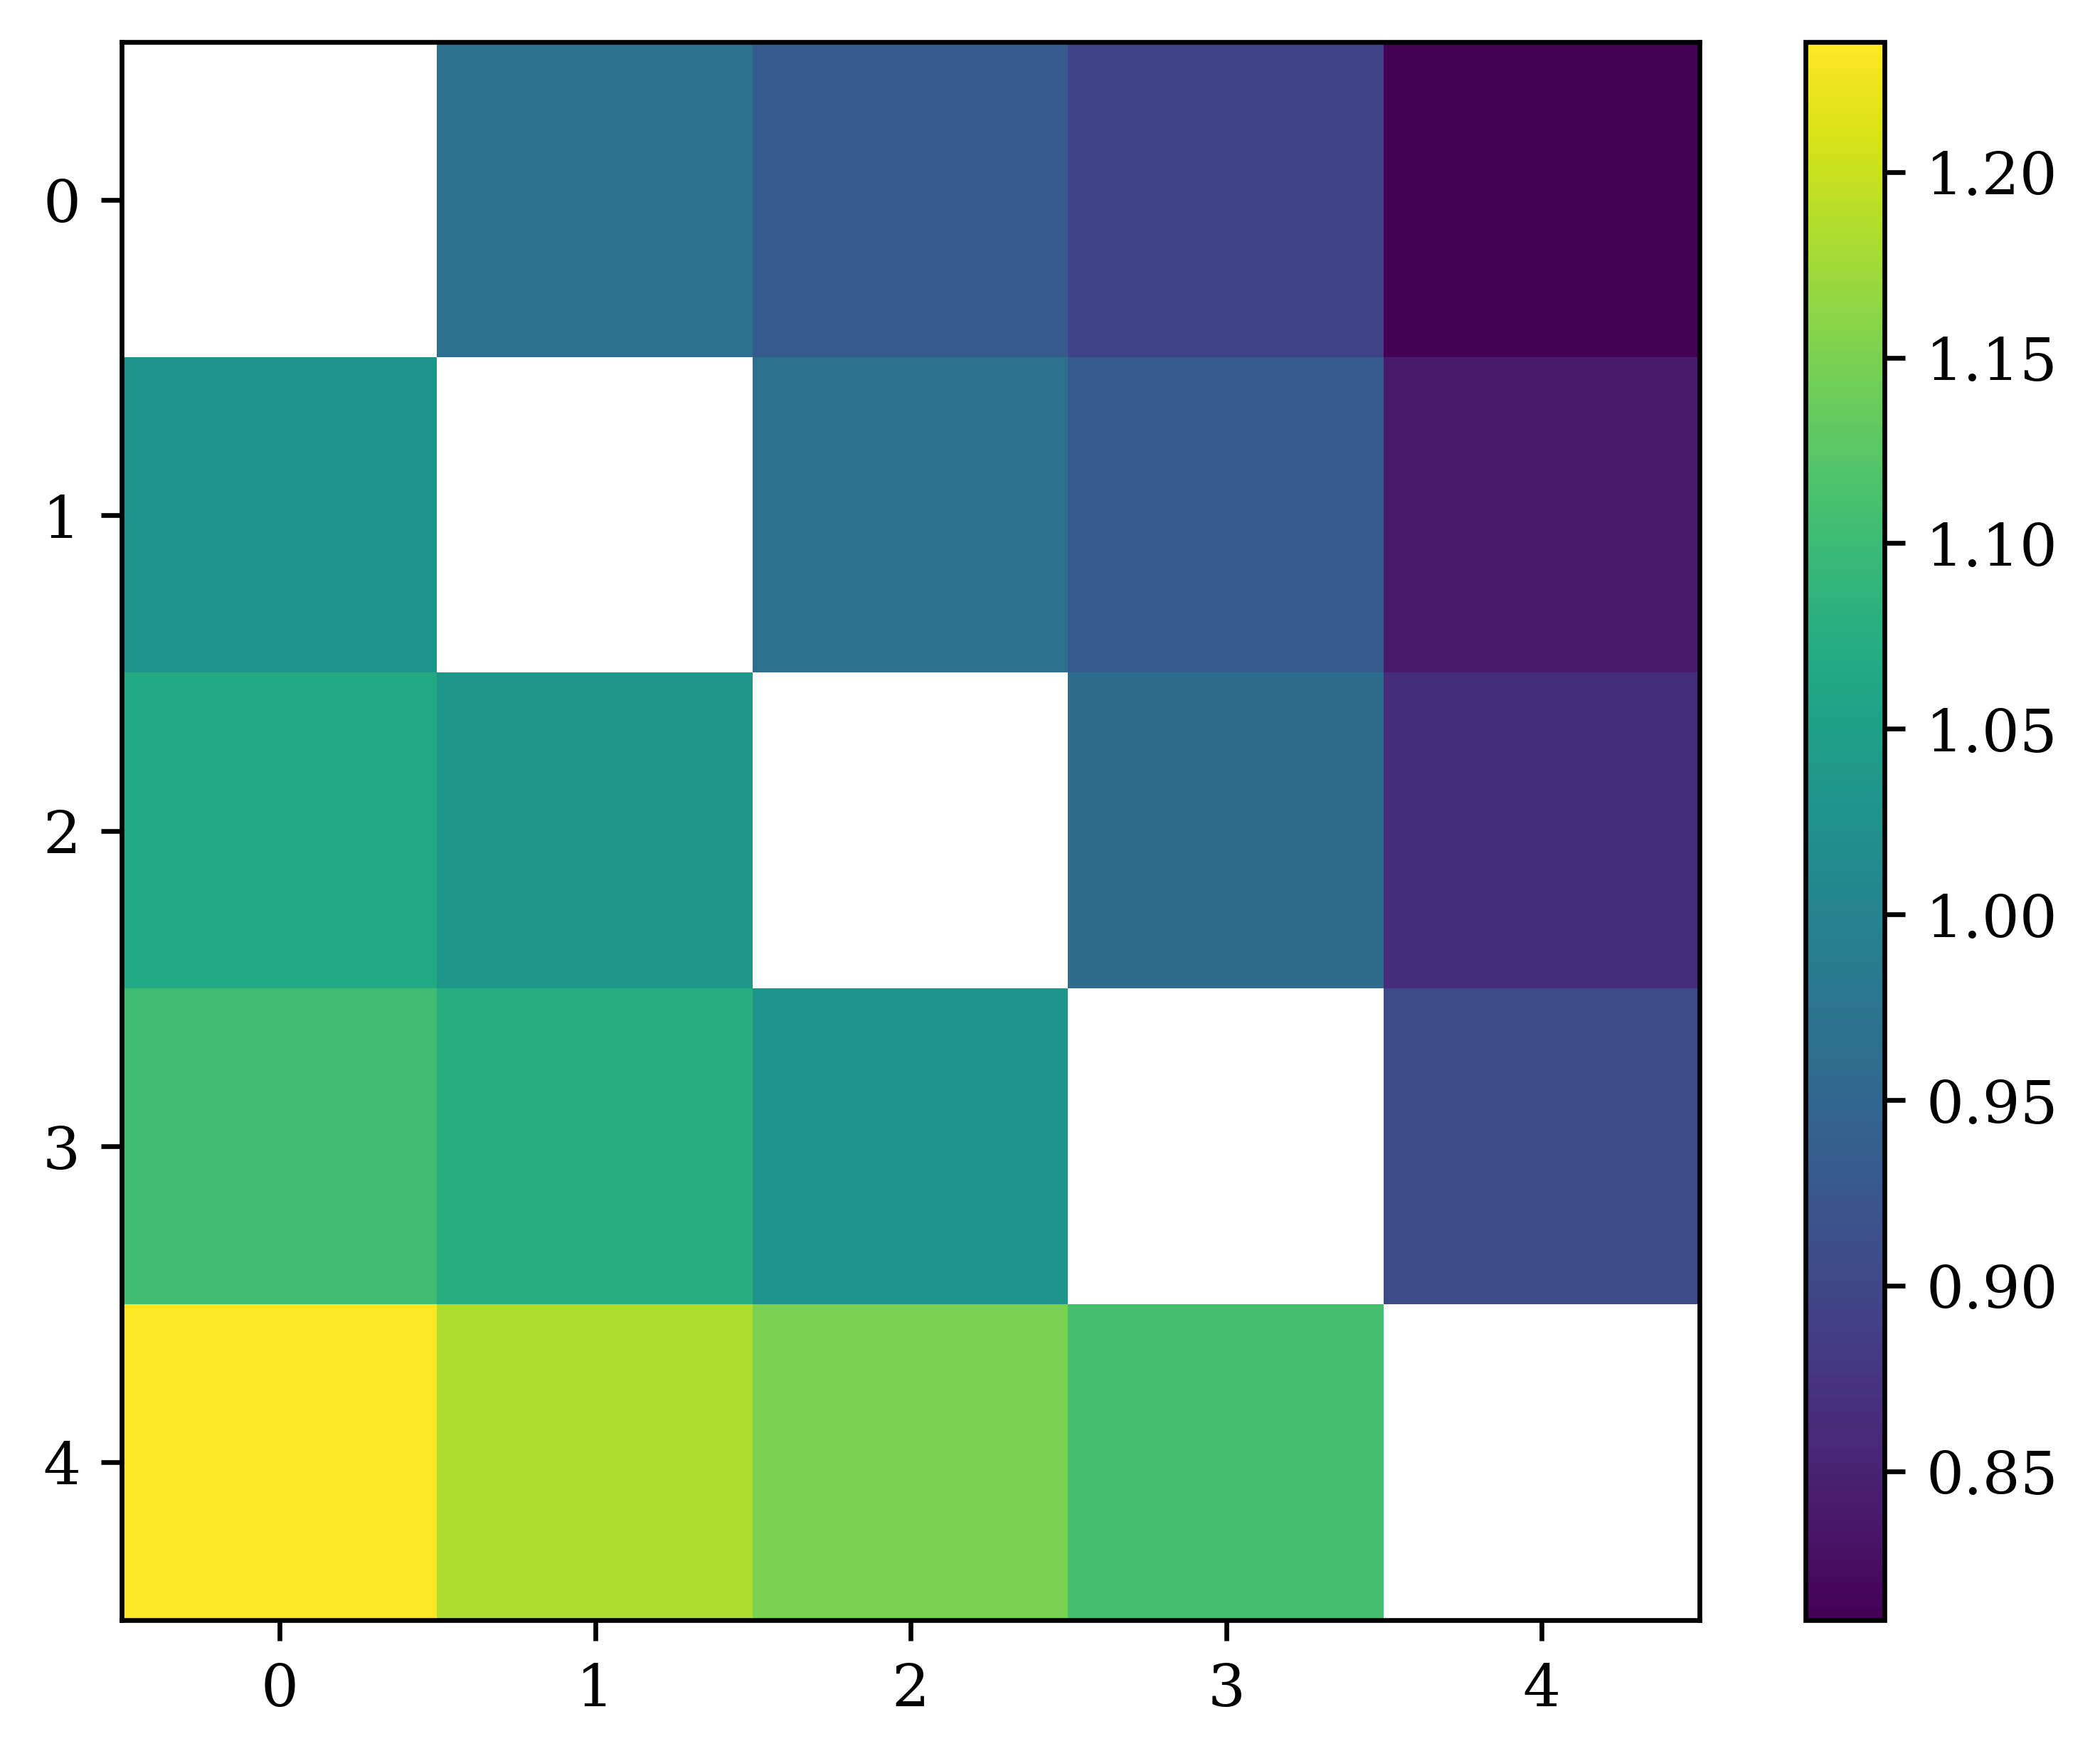

In [19]:
plt.imshow(mtx)
plt.colorbar()

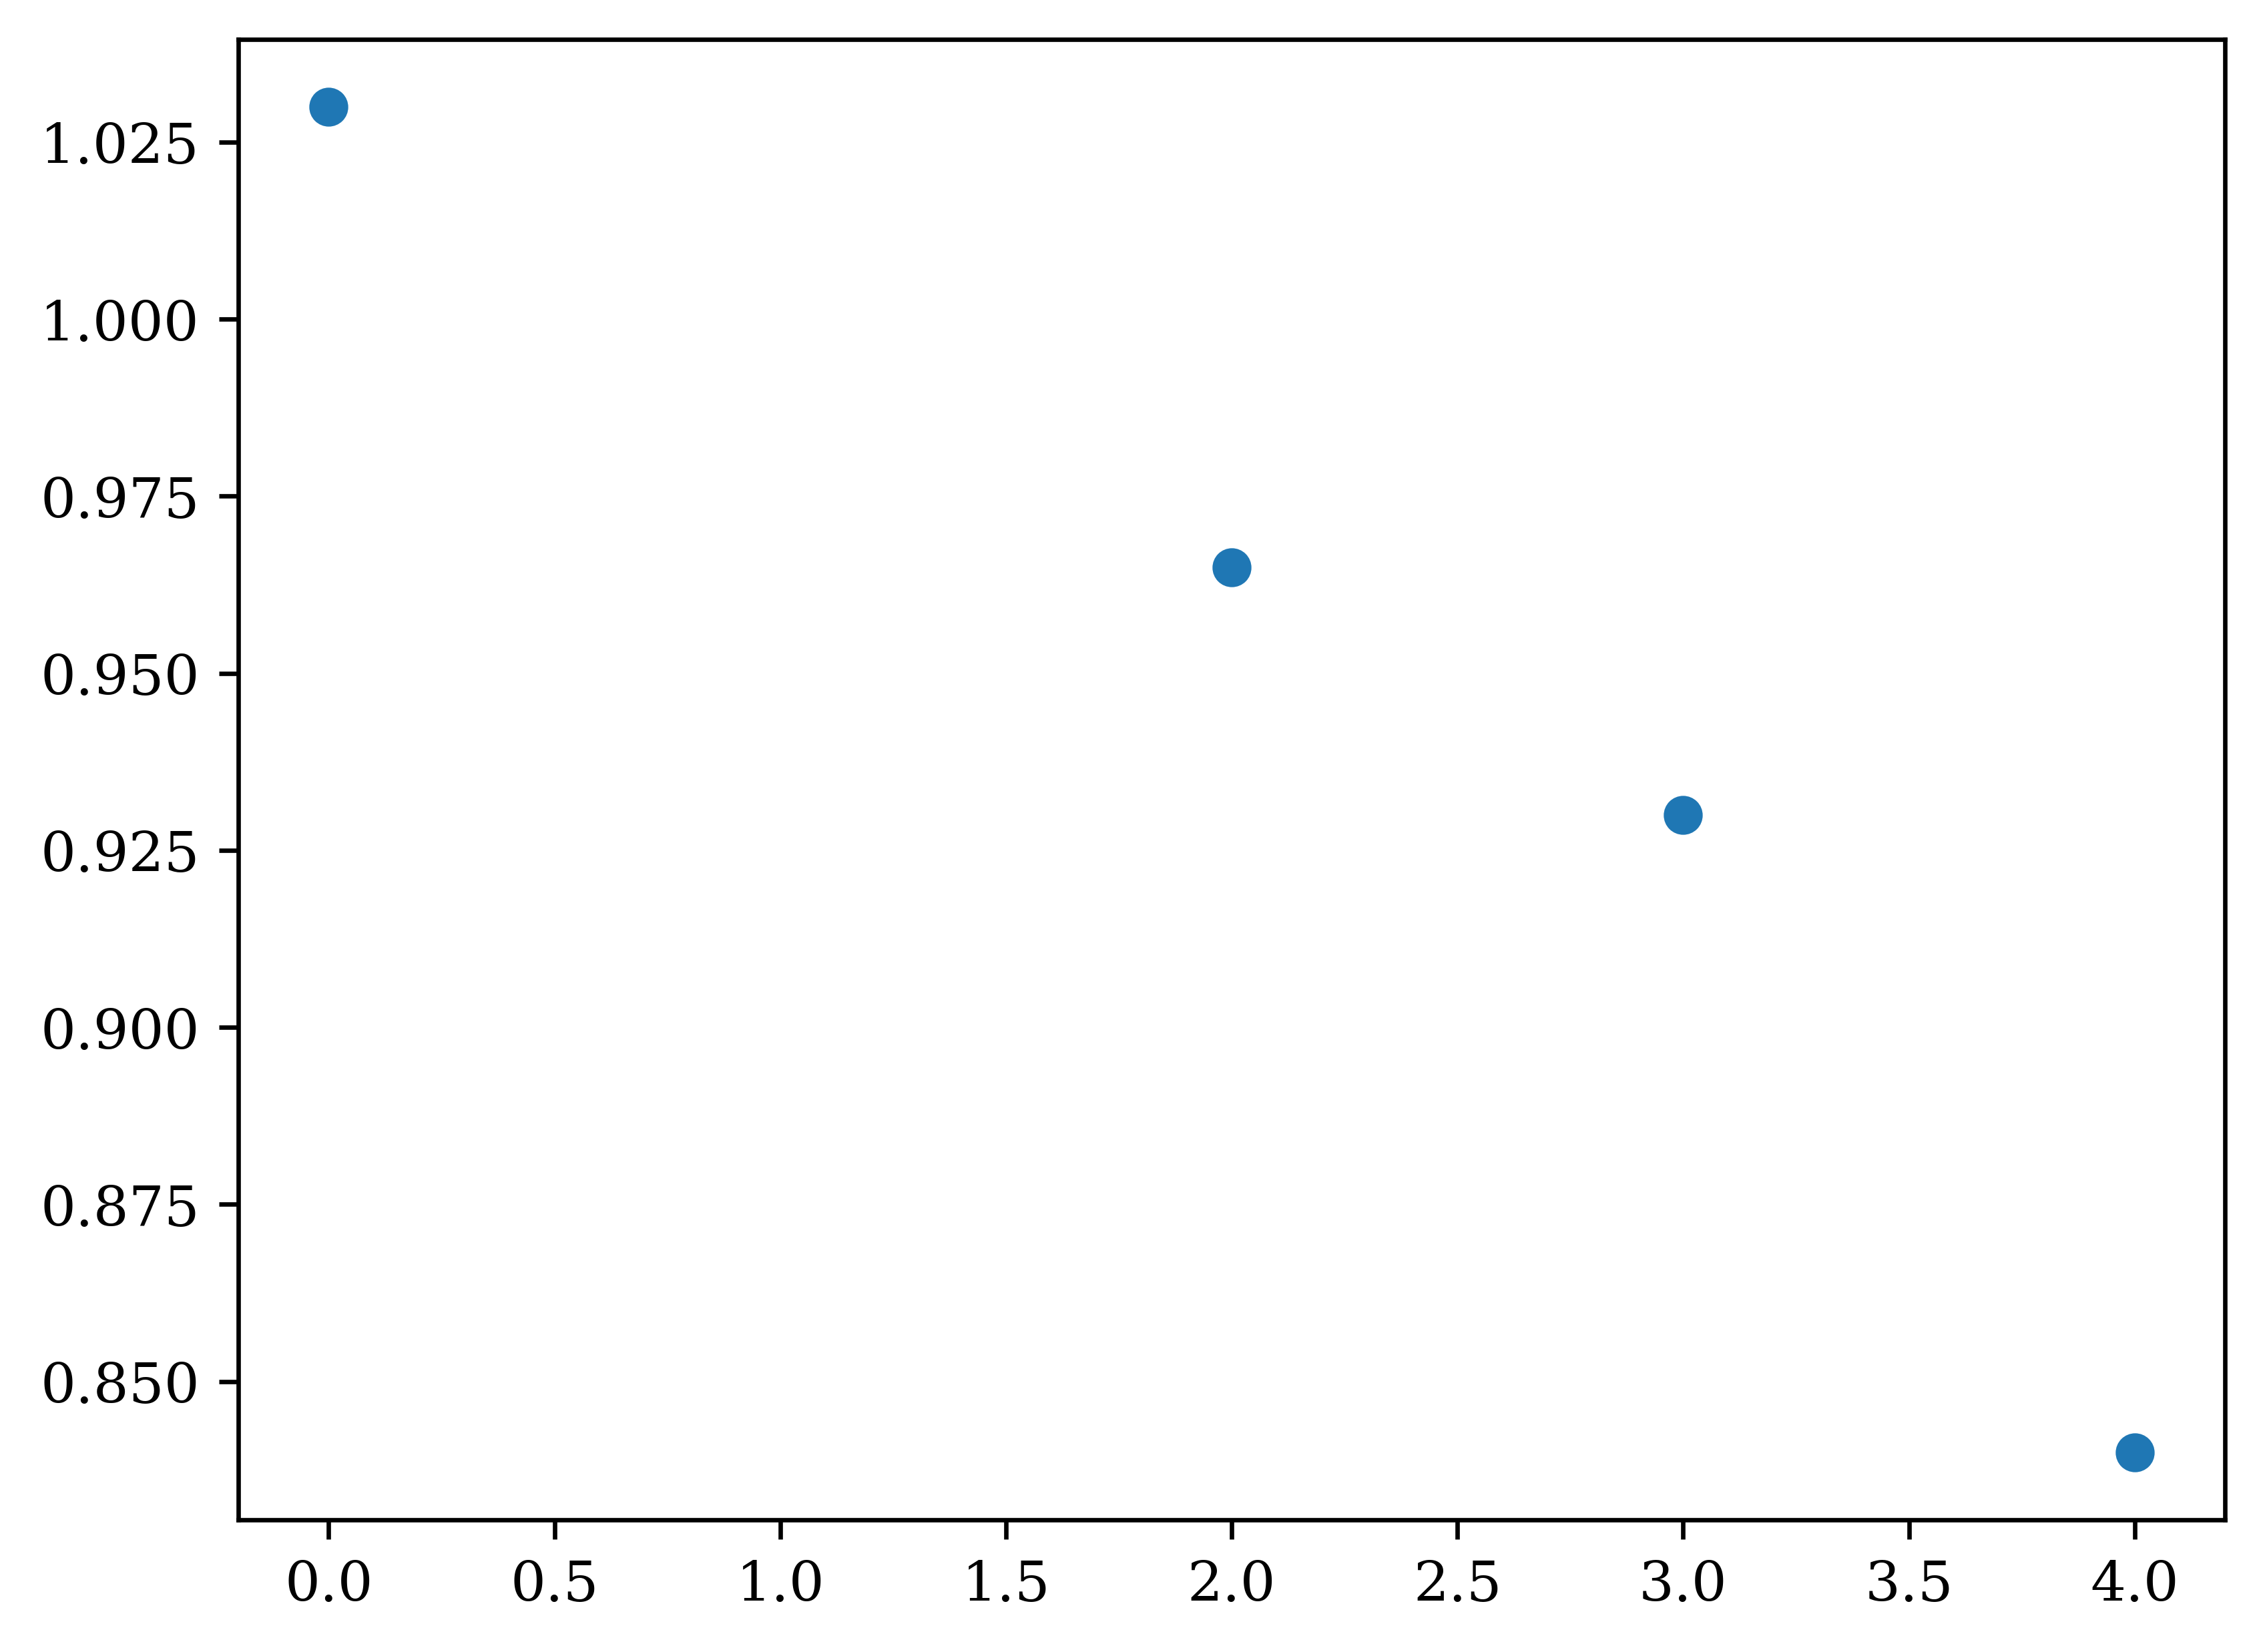

In [20]:
plt.plot(mtx[1], 'o')

In [21]:
all_factors = {}
all_mtx = {}
for mouse, _files in tqdm(file_grp.items()):
    _, _, out_filter = gather_mouse_data(_files)
    factors, mtx = compute_scalings(out_filter)
    all_factors[mouse] = factors
    all_mtx[mouse] = mtx

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/tmp/ipykernel_5131/3481646326.py:8: RuntimeWarning: invalid value encountered in divide
  height[td] = np.sum(h5f["frames"] * (h5f["frames"][()] > 10), axis=(1, 2)) / np.sum(


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [22]:
valmap(np.nanmax, all_mtx)

{'C1_N': 1.22,
 'C1_L': 1.2349999999999999,
 'C1_R': 1.195,
 'C1_RL': 1.185,
 'C1_RR': 1.2349999999999999,
 'C2_L': 1.17,
 'C2_N': 1.1800000000000002,
 'C2_R': 1.185}

In [23]:
valmap(np.nanmin, all_mtx)

{'C1_N': 0.815,
 'C1_L': 0.8049999999999999,
 'C1_R': 0.835,
 'C1_RL': 0.845,
 'C1_RR': 0.81,
 'C2_L': 0.855,
 'C2_N': 0.8400000000000001,
 'C2_R': 0.8400000000000001}

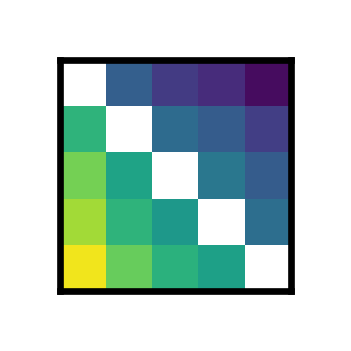

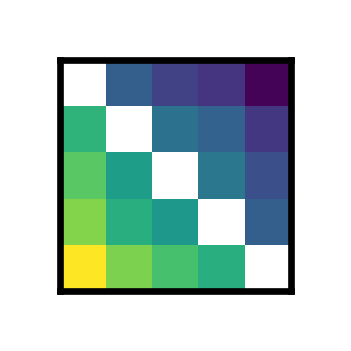

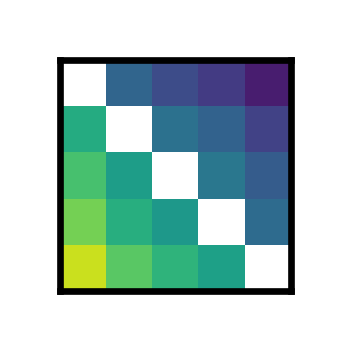

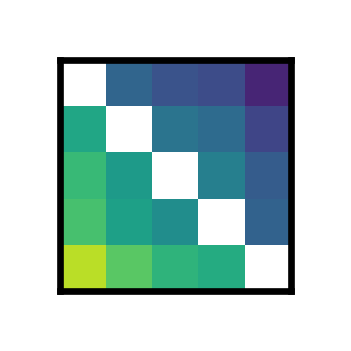

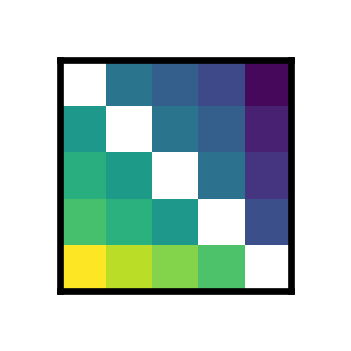

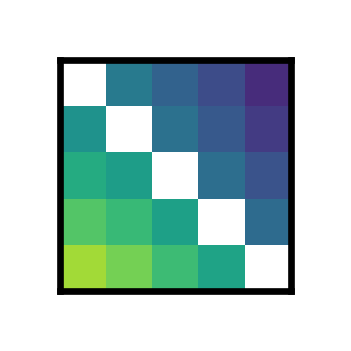

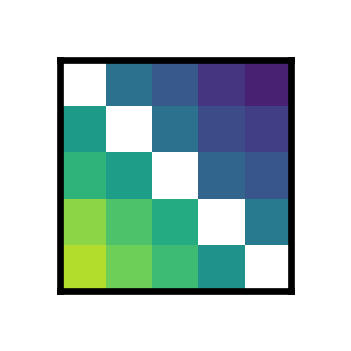

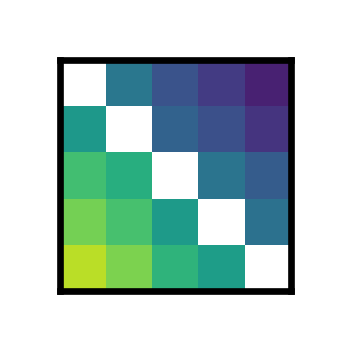

In [24]:
for k, v in all_mtx.items():
    plt.figure(figsize=(0.5, 0.5))
    plt.imshow(v, vmin=0.8, vmax=1.23)
    plt.xticks([])
    plt.yticks([])

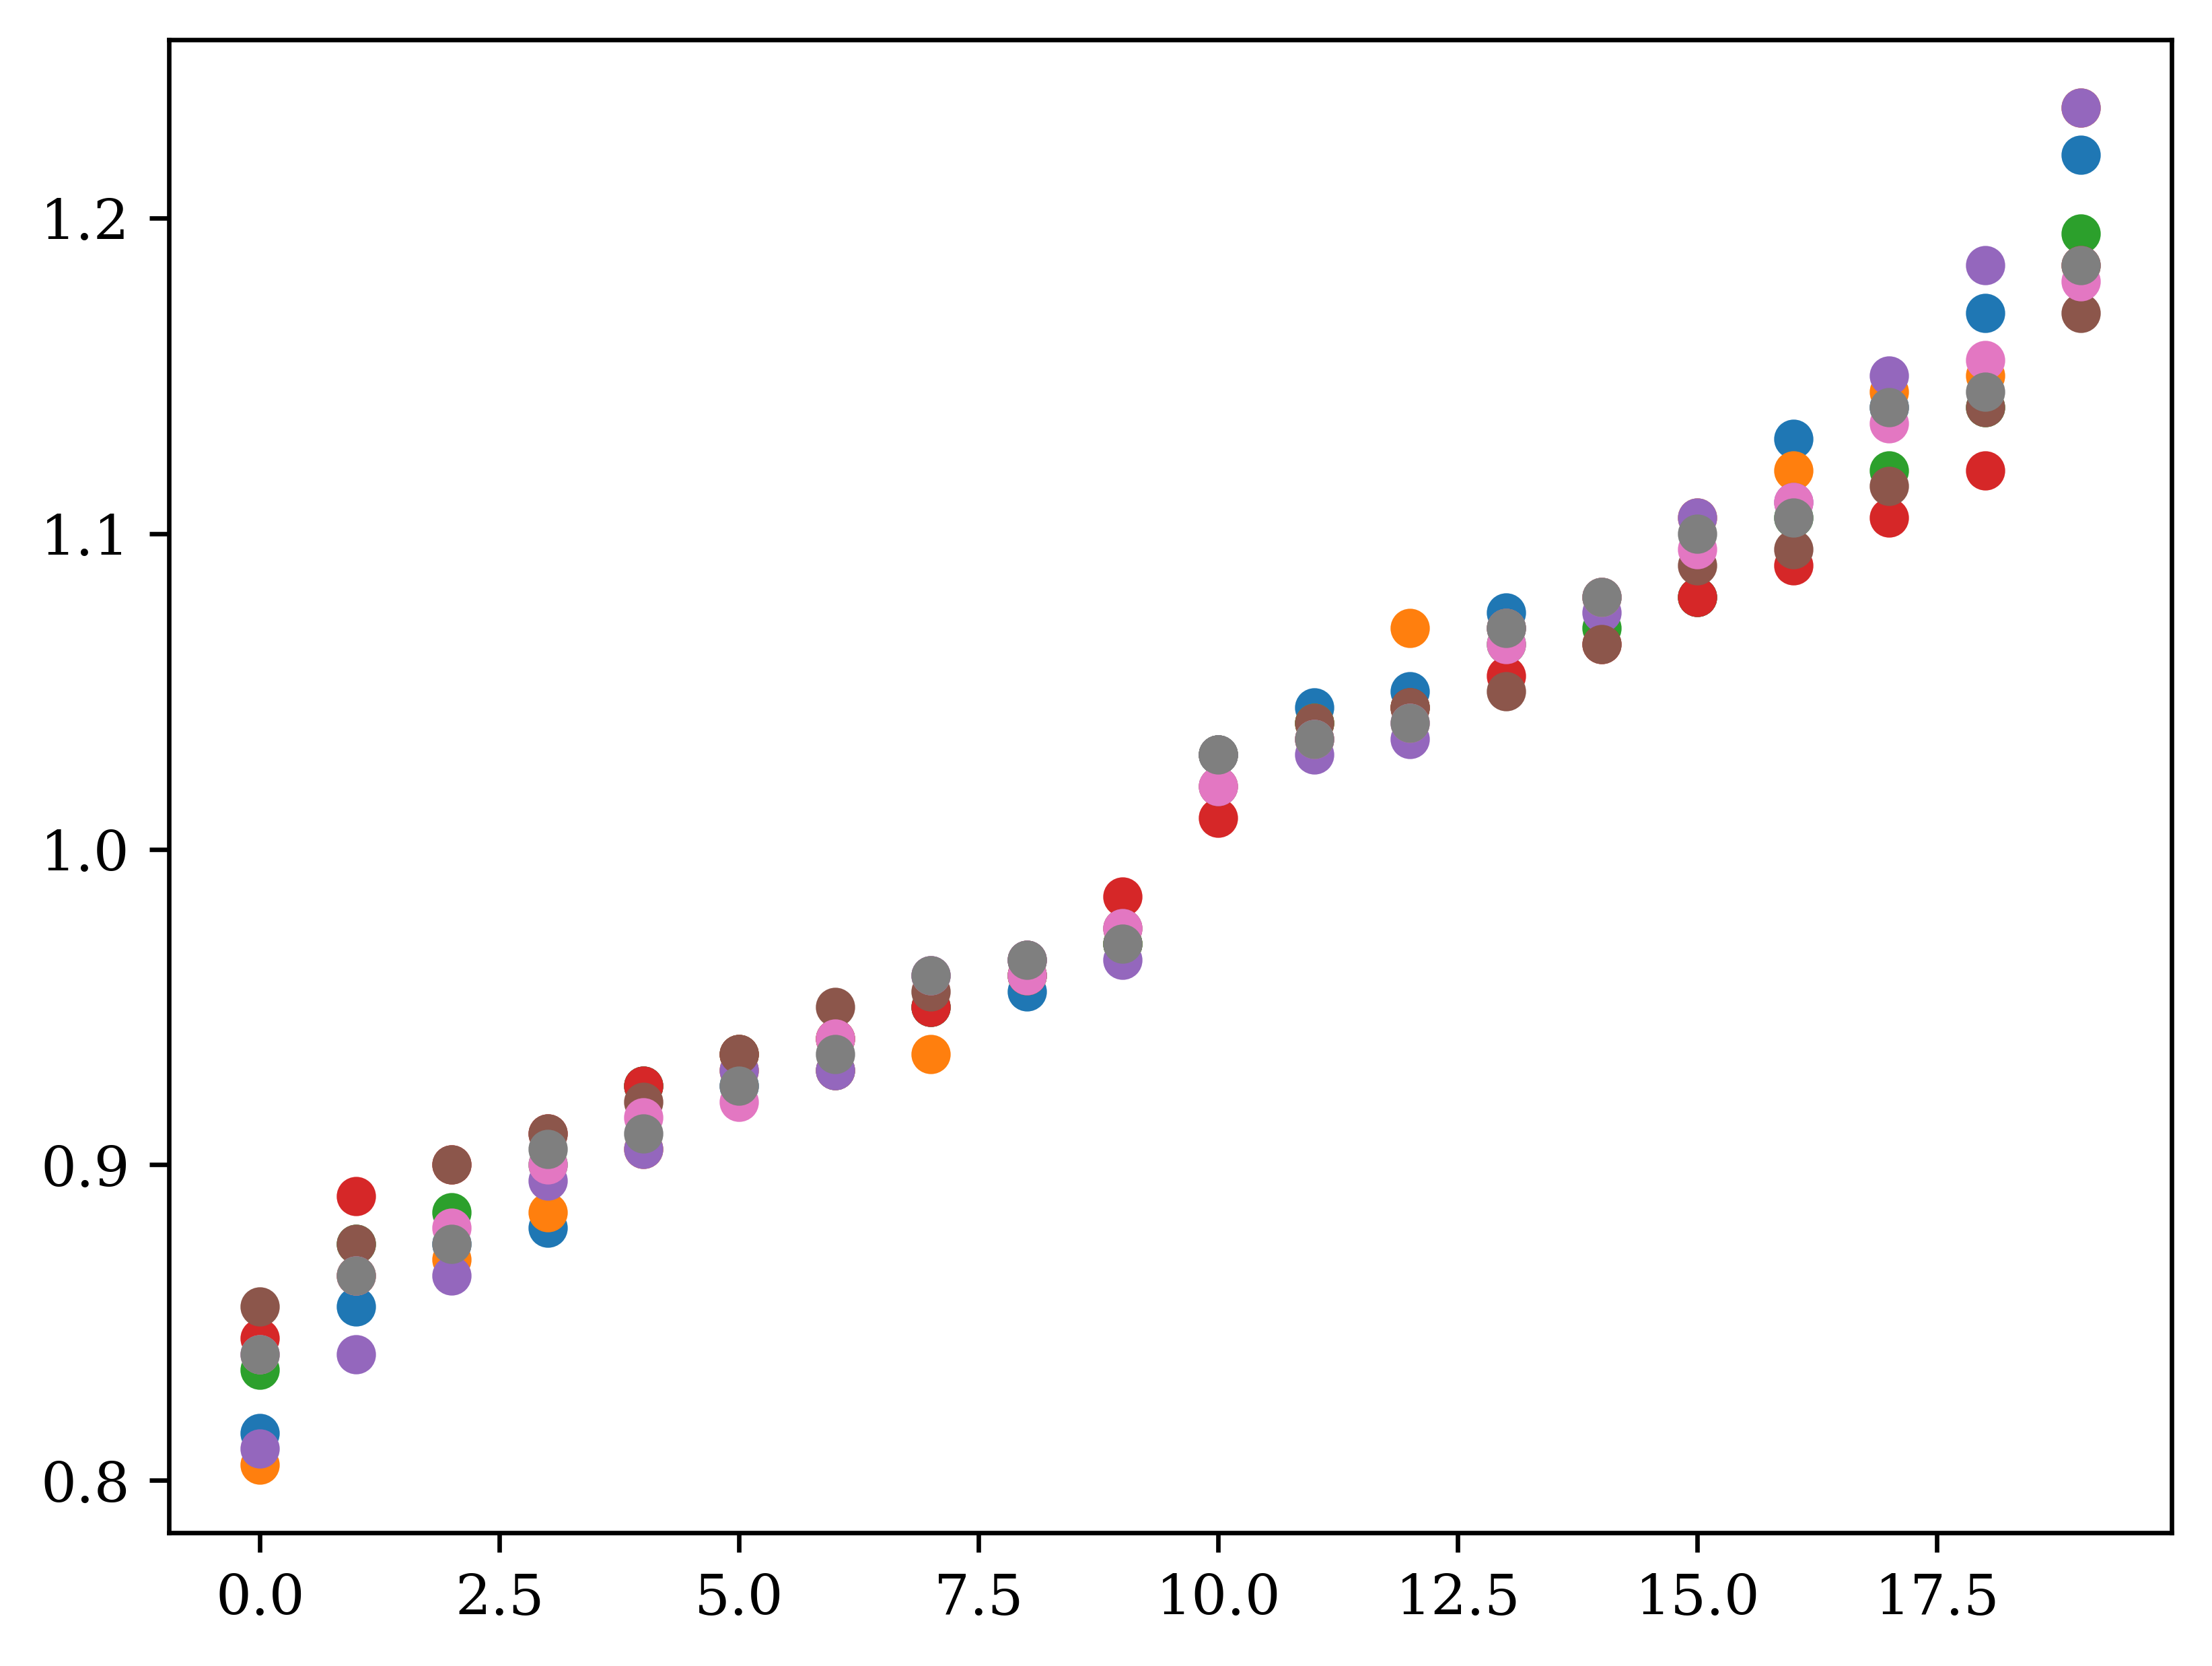

In [25]:
for k, v in all_mtx.items():
    plt.plot(np.sort(v.flatten()), 'o')

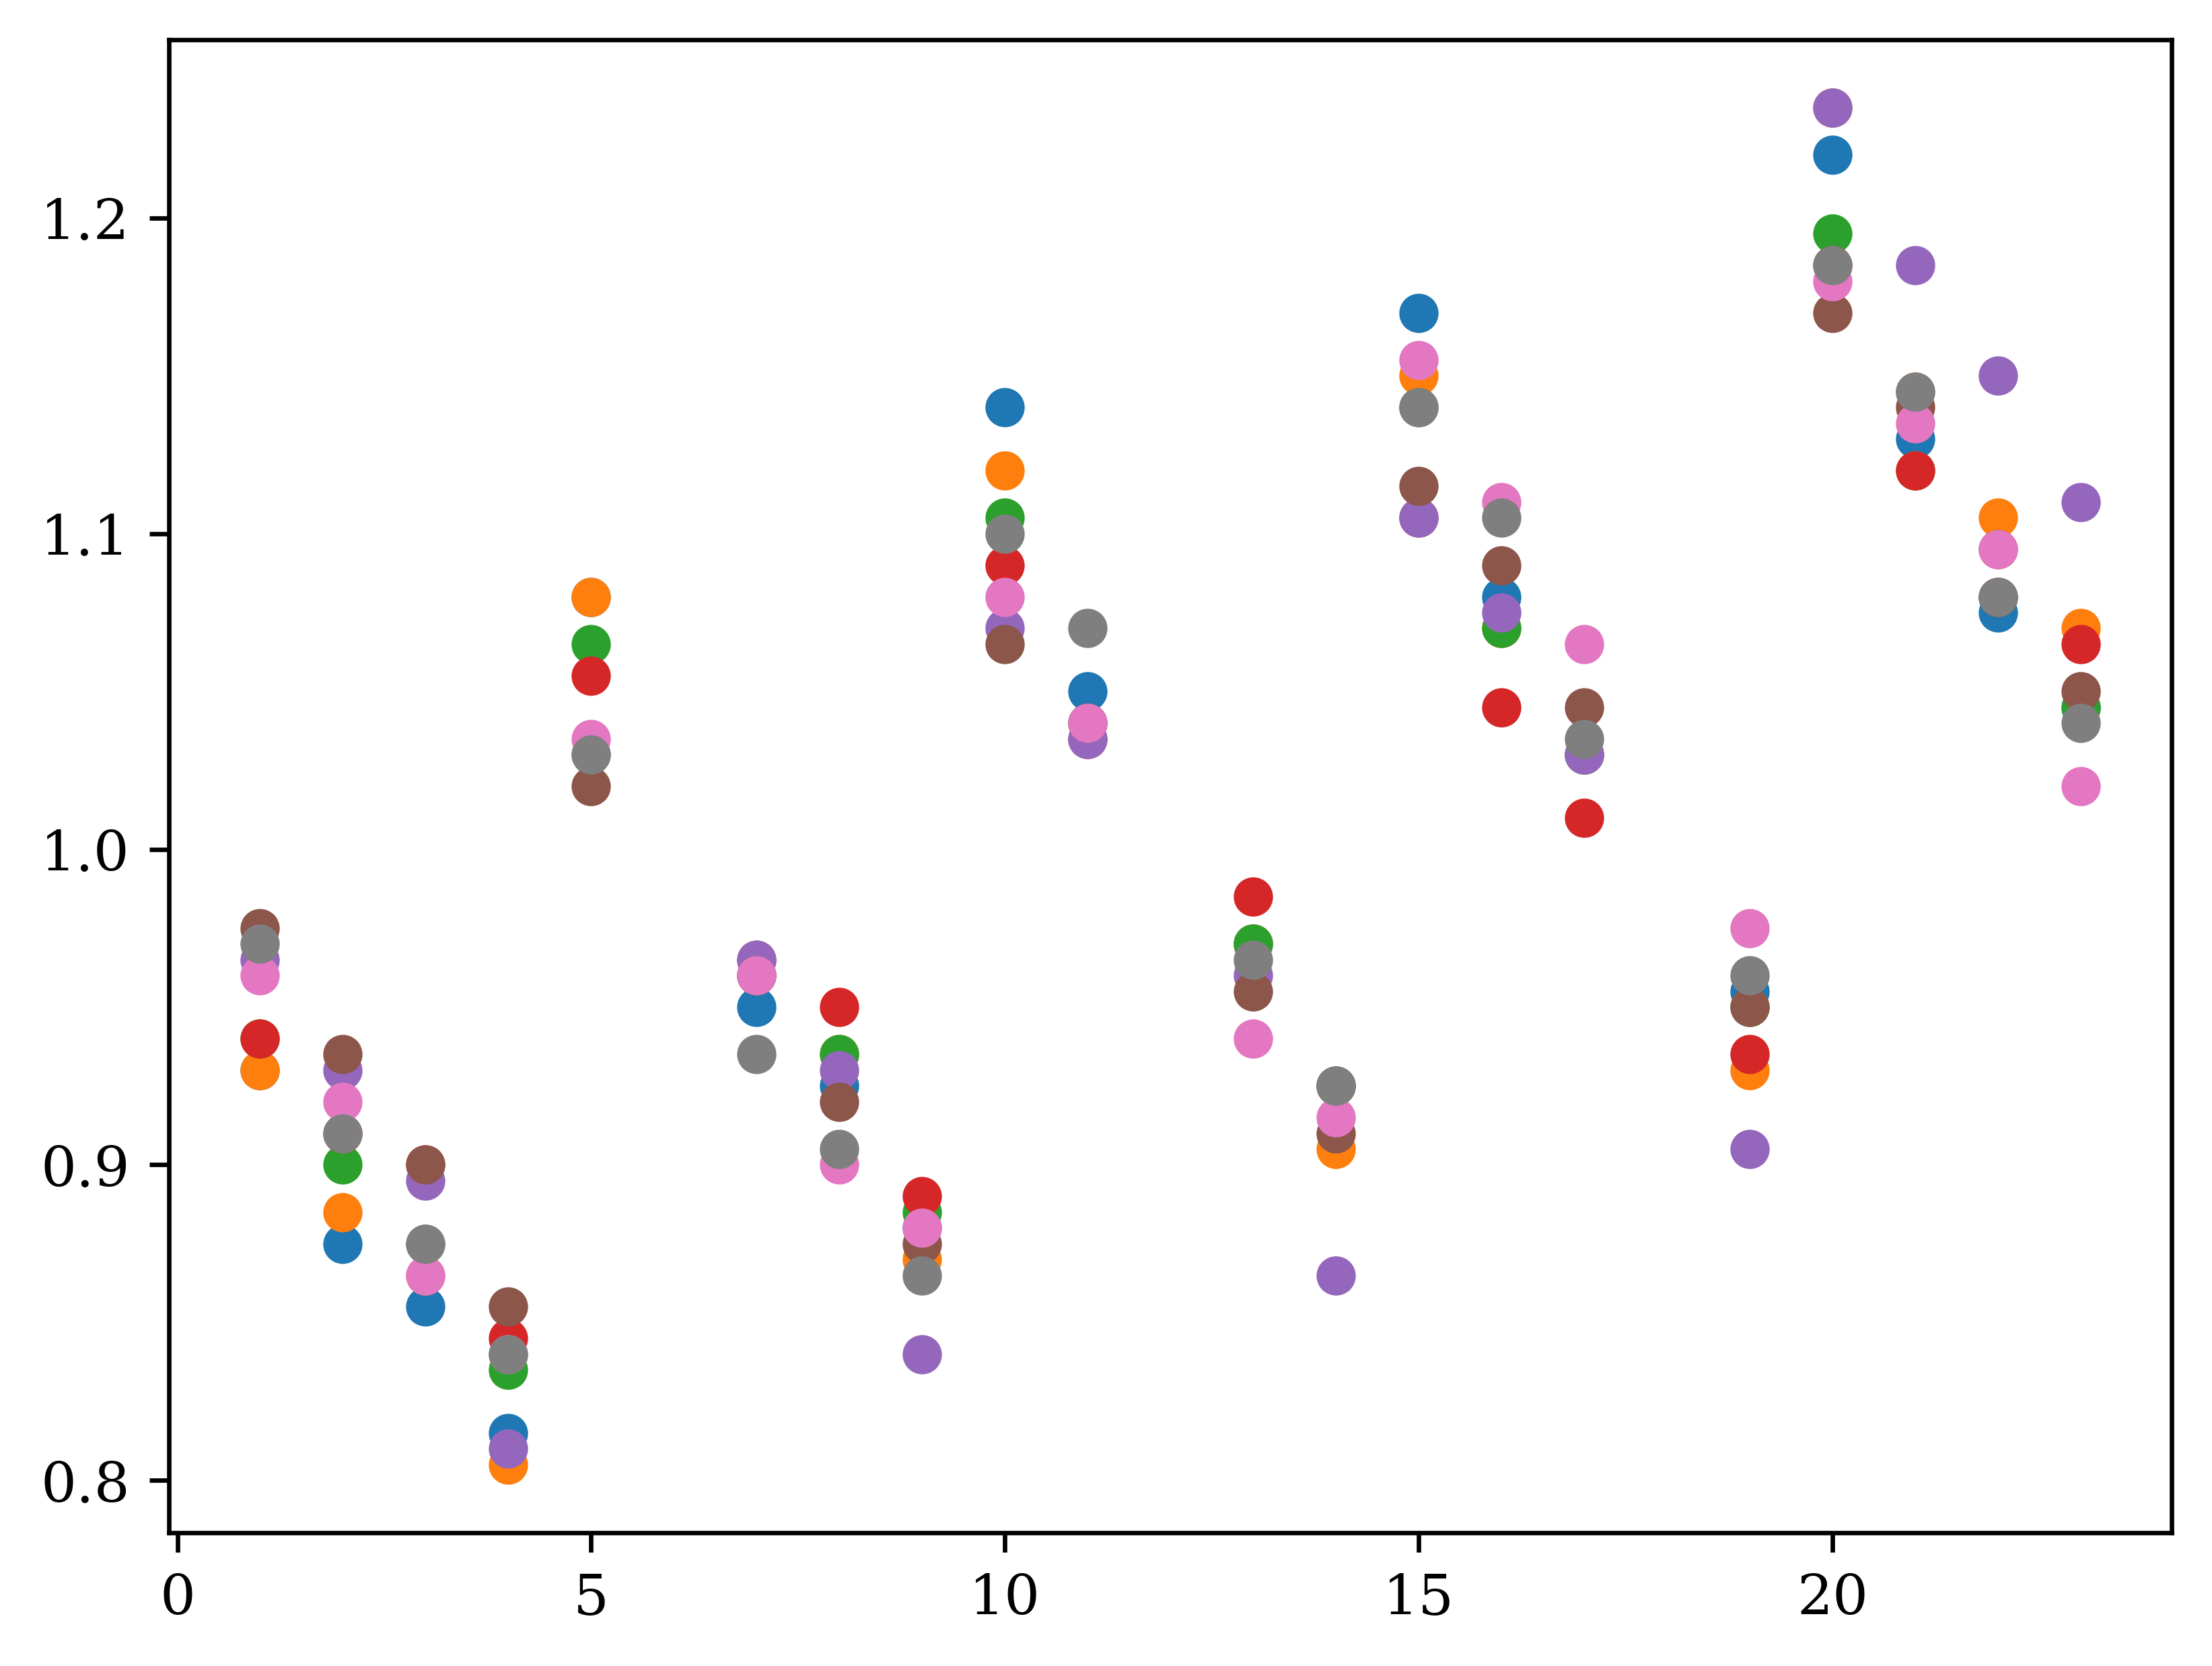

In [26]:
for k, v in all_mtx.items():
    plt.plot(v.flatten(), 'o')

In [27]:
x = []
y = []
z = []

for mouse, d in all_factors.items():
    for k, v in d.items():
        x.append(k[0])
        y.append(k[1])
        z.append(v)

In [28]:
arr = np.array([x, y, z]).T

In [29]:
arr.shape

(200, 3)

In [30]:
centroid = np.mean(arr, axis=0)

In [31]:
pts = arr - centroid

In [32]:
cov = np.cov(pts.T)

In [33]:
cov.shape

(3, 3)

In [34]:
eigenvalues, eigenvectors = np.linalg.eig(cov)
normal = eigenvectors[:, np.argmin(eigenvalues)]

In [35]:
normal

array([-0.00175665,  0.00175147,  0.99999692])

In [36]:
mtxs = []
for k, v in all_mtx.items():
    mtxs.append(v)

mtxs = np.median(mtxs, axis=0)

In [37]:
mtxs

array([[   nan, 0.95  , 0.91  , 0.875 , 0.8375],
       [1.045 ,    nan, 0.96  , 0.9275, 0.8775],
       [1.095 , 1.04  ,    nan, 0.9675, 0.92  ],
       [1.14  , 1.0775, 1.03  ,    nan, 0.95  ],
       [1.19  , 1.1375, 1.0875, 1.0475,    nan]])

In [38]:
normal.dot(np.array([595, 700, centroid[2]]) - centroid) + centroid[2]

1.1871934262840138

In [39]:
normal.dot(np.array([700, 595, centroid[2]]) - centroid) + centroid[2]

0.8188412984489517

In [4]:
def predict(input_depth, target_depth, normal, centroid):
    return (
        normal.dot(np.array([input_depth, target_depth, centroid[2]]) - centroid)
        + centroid[2]
    )

In [41]:
joblib.dump(
    dict(normal=normal, centroid=centroid),
    "/n/groups/datta/win/longtogeny/data/metadata/floor_adjustment_params.p",
)

['/n/groups/datta/win/longtogeny/data/metadata/floor_adjustment_params.p']